In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the preprocessed dataset
df = pd.read_csv("../data/processed_bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Display dataset
df.head()

,Open,High,Low,Close,Volume,Close_Scaled,Prediction
Date,,,,,,,
2021-01-02,32127.267578,33155.117188,29091.181641,29376.455078,67865420765,0.150436,0.191803
2021-01-03,32782.023438,34608.558594,32052.316406,32129.408203,78665235202,0.180901,0.196436
2021-01-04,31971.914062,33440.218750,28722.755859,32810.949219,81163475344,0.188443,0.218320
2021-01-05,33992.429688,34437.589844,30221.187500,31977.041016,67547324782,0.179215,0.240058
2021-01-06,36824.363281,36879.699219,33514.035156,34013.613281,75289433811,0.201752,0.234042


In [14]:
# Function to create sequences of past n_steps days
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Set the number of past days to use for predictions
n_steps = 30

# Prepare input (X) and target (y)
X, y = create_sequences(df["Close_Scaled"].values, n_steps)

# Split into training (80%) and testing (20%) sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1154, 30, 1)
Testing data shape: (289, 30, 1)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Define a more powerful LSTM model
model = Sequential([
    Input(shape=(n_steps, 1)),  # Input shape: 30 days, 1 feature
    LSTM(100, return_sequences=True),  # Increase LSTM neurons
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model again
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0156 - val_loss: 0.0030
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 9.4730e-04 - val_loss: 0.0027
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0010 - val_loss: 0.0074
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0010 - val_loss: 0.0013


In [16]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save the new model
model.save("../models/lstm_model.keras")
print("✅ LSTM model retrained and saved!")



Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.9451e-04 - val_loss: 0.0015
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 7.5173e-04 - val_loss: 0.0017
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 7.9083e-04 - val_loss: 0.0011
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 7.6508e-04 - val_loss: 0.0025
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.0075e-04 - val_loss: 0.0011
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 9.8405e-04 - val_loss: 0.0015
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.8810e-04 - val_loss: 0.0018
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 7.7182e-04 - val_loss: 0.0015
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 7.5881e-04 - val_loss: 0.0013
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 7.4097e-04 - val_loss: 0.0025
✅ LSTM model retrained and saved!


In [17]:
# Make predictions
predictions = model.predict(X_test)

# Convert predictions back to original scale
predictions_rescaled = np.interp(predictions, (0, 1), (df["Close"].min(), df["Close"].max()))
y_test_rescaled = np.interp(y_test, (0, 1), (df["Close"].min(), df["Close"].max()))

# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Mean Absolute Error (MAE): 3668.99
Mean Squared Error (MSE): 20636008.86


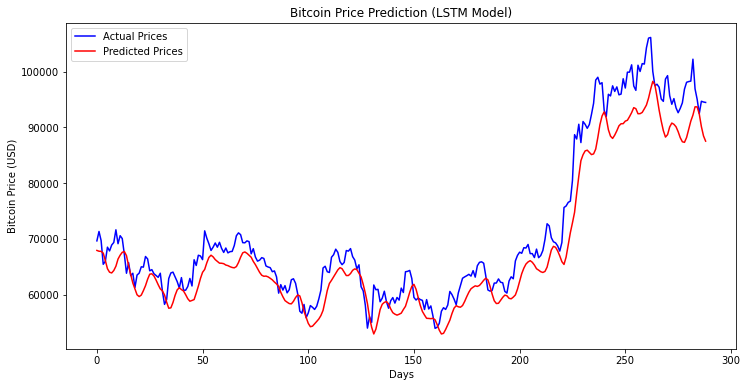

In [18]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(predictions_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Bitcoin Price (USD)")
plt.title("Bitcoin Price Prediction (LSTM Model)")
plt.show()
